# Sort and convert ultrasound recordings
## General Informations about data structure
Clarius Output:
- one DICOM-File per recording
    - first scanner: 0_0, 0_1, ... (should be C3)
    - second scanner: 1_0, 1_1, ... (should be L15)
- tar-Files:
    - somehow, when you change the scanner in an examination, the Clarius-App doubles all tar-files 
    - original files: 0_0, 0_1, 0_2, ... (beware numbering is maintained even when the scanner is changed, therefore differs from the numbering of the DICOM files)
    - doubled files: 1_0, 1_1, 1_2, ...
    - content of Tar files:
        - env.raw.lzo   -> lzop-compressed envelope data 
        - env.tgc       -> meta-informations about time gaine compensation in envelope
        - env.yml       -> meta-informations about envelope data
        - rf.raw.lzo    -> lzop-compressed rf-data 
        - (rf.tgc)      -> not in every recording
                        -> meta-informations about time gaine compensation in rf-data
                        -> also in yaml-files -> differences?
        - rf.yml        -> meta-informations about rf-data

## Data flow:

### Overview
1. Hand copy the data into specific folders
2. tar files and LZO files are unopacked
3. Generate a new Folder for each measurement with extracted RF(as numpy), YAML (as YAML), TGC (as txt), DICOM (as Numpy) in  choosen end_directory for each measurement; 
4. Rename files according to used transducer and checking the files in comparison with the YAML, creates a list of suspicious files
5. Pseudonymise the files according to local ID
6. Substract the TGC and split into 2 Files: _no_TGC for files where TGC has been removed and second version where TGC is still contained

### 1. Selection of files under investigation
- at first saved in a folder "Patientenaufnahmen/Elastographieaufnahmen_" + date_oflast recording included  
- to work on files, they have to be copied into a folder named "Testdata" (working on all files at onced might take very much time, because in the pipeline all files in the directory *Testdata* are processed)

### 2.1 Tar-files unpacking:


### 2.1 Lzo decompression:

### 3. Data conversion and transfer:
- create new folder for every recording in *end_directory* (*finished_data*) where converted data is safed
- load, change and safe rf.yaml-files (yaml-files need to be changed because Clarius uses wrong character combinations)
- extract data arrays out of rf- and DICOM-files and safe them as numpy-arrays
    - rf-array[scan_lines, pixel_depth, frames]

### 4. Renaming files and checking for Errors:
- rename files according to the numbering Clarius gave them
    - when there are mistakes in the order of recordings, the files will get wrong names
- checking if there are any mistakes in the namings by checking the informations given in the yaml-file
- giving out a list of recordings with mistakes -> they have to be checked and either changed or sorted out by hand
    - recordings recordings with unsolvable errors are saved in *recordings_with_mistakes*

### 5. Pseudonymise recordings:
- rename directories based on the encoding in *Users/jakobschaefer/Library/CloudStorage/OneDrive-Persönlich/HybridEcho/Forschung/Erfassung_Ultraschalluntersuchungen.xlsx* (Fallnummer -> RedCap-ID)


### 6. Cleansing the the time gain compensation from the signals
- TGC-Information in .tgc-file, if no .tgc-file exists the tgc given in the yaml-files under "tgc" is used
- safe changed files under ...rf_no_tgc.npy

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as ff
import sys
sys.path.insert(0, '..')  # necessary to import functions from other directory
import functions.definitions as definitions
import yaml # install module called PyYAML
import shutil
import openpyxl
from scipy.signal import hilbert
import re
from scipy import stats
from scipy.signal import get_window
from tqdm.notebook import tqdm
import h5py


In [8]:
# Chose start_directory and end_directory (conains unsorted ultrasound data) and end_directory (directory where sorted and converted data should be stored)
# choose if you want to process all recordings or only new ones
process_recordings = 'new' # 'all' or 'new' 
# if you choose new, you have to copy the files by hand from Elastographieaufnahmenen to Testdata
version = 'Vortraining_Tim'

if process_recordings == 'all':
    start_directory = "/Volumes/Extreme_SSD/Patientenaufnahmen/Elastographieaufnahmenen_"+version # directory with data as Clarius outputs it 
    # copy data into new_directory to process it without changing the original data
    new_directory = "/Volumes/Extreme_SSD/Patientenaufnahmen/Testdata"
    # check if directory exists and create it if not
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    # if you want to process all recordings check if directory is empty and copy data if it is
    if not os.listdir(new_directory):
        shutil.copytree(start_directory, new_directory)

# define directory with copied data as new start_directory
start_directory = "/Volumes/Extreme_SSD/Patientenaufnahmen/Testdata"
end_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data_'+version

# if end_directory does not exist, create it
if not os.path.exists(end_directory):
    os.makedirs(end_directory)

In [9]:
# remove directories and files starting with '._'
import os
import tarfile


for dir in os.listdir(start_directory):
    if dir.startswith('.'):
        try:
            os.rmdir(start_directory + '/' + dir)
            print('removed ' + dir)
        except:
            print('Could not remove directory: ' + dir)
        
    else:
        for file in os.listdir(start_directory+'/'+dir):
            if file.startswith('._'):
                try:
                    os.remove(start_directory + '/' + dir + '/' + file)
                    print('removed ' + file)
                except:
                    print('Could not remove file: ' + file)
    

In [4]:
# unpack all tar-files in the start_directory

for root, dirs, files in tqdm(os.walk(start_directory)):
    for name in files:
        try:
            if name.startswith('._'):
                os.remove(os.path.join(root, name))
                
            if name.endswith('.tar') and not name.startswith('._'):
                tar = tarfile.open(os.path.join(root, name))
                tar.extractall(path = root+'/'+name[:-4])
                tar.close()
                os.remove(os.path.join(root, name)) 
        except:
            print('Error in: ', os.path.join(root, name))

0it [00:00, ?it/s]

In [5]:
# decompress all lzo-files in the start_directory

for root, dirs, files in tqdm(os.walk(start_directory)):  
    for name in files:
        if name.endswith(('rf.raw.lzo','env.raw.lzo')):
            name_length = len(name)
            file_path = os.path.join(root, name)
            os.system('lzop -d {}'.format(file_path))

0it [00:00, ?it/s]

In [10]:
# convert data into arrays and safe them in extra directory
for patient in tqdm(os.listdir(start_directory)):
    
    # remove doubled files
    # somehow the Clarius-App duobles all tar-files when you change the scanner in a examination
    # original files are named "raw_0_X" and doubled files are named "raw_1_X", with X=number of recording
    if os.path.isdir(start_directory+"/"+patient):
        for sub_dir in os.listdir(start_directory+"/"+patient):  
            if sub_dir.startswith(('raw_1')):
                if os.path.isdir(start_directory+"/"+patient+"/"+sub_dir):
                    shutil.rmtree(start_directory+"/"+patient+"/"+sub_dir) 

    #create sub-end_directory for every patient
    if not os.path.exists(end_directory+"/"+patient):
            os.mkdir(end_directory+"/"+patient)
            
    # check if there allready files in goal directory
    if os.path.isdir(end_directory+"/"+patient):
        if len(os.listdir(end_directory+"/"+patient)) == 0:  
            for recording in os.listdir(start_directory+"/"+patient):

                # Search DICOMs, extract b-mode-array and save it. 
                if recording.endswith(('.dcm')):
                    # define pathof the changed files in the end_directory
                    end_path = end_directory+"/"+patient+"/"+recording   

                    file = start_directory+"/"+patient+"/"+recording
                    dcm_array, dcm_array_and_meta = definitions.read_DICOM(file)
                    dcm_time = int(dcm_array_and_meta.ContentTime[:6])-int(dcm_array_and_meta.TimezoneOffsetFromUTC[1:])*100 
                    dcm_time_and_array = [dcm_time, dcm_array]
                    np.save(os.path.dirname(end_path)+"/"+recording,dcm_time_and_array)

                if os.path.isdir(start_directory+"/"+patient+"/"+recording):  
                    # define end path of the changed files in the end_directory
                    end_path = end_directory+"/"+patient+"/"+recording

                    for file in os.listdir(start_directory+"/"+patient+"/"+recording):
                        file_path = start_directory+"/"+patient+"/"+recording+"/"+file

                        # search yaml-file, load it, change it and safe it in new directory
                        if file.endswith('rf.yml'):
                            loaded_yaml = definitions.change_and_load_yaml_pipeline(file_path, end_path)
                            sampling_rate = int(loaded_yaml['sampling rate'][:-4])*1e6 #Hz
                            imaging_depth = float(loaded_yaml['imaging depth'][:-3]) #mm
                            if 'vsound'  in loaded_yaml:
                                soundspeed = int(loaded_yaml['vsound'][:-4]) #m/s
                            else:
                                soundspeed = 1450 #m/s
                        
                        if file.endswith('rf.raw'):
                            rf_data = definitions.load_rf_image(file_path) #numframes -> number of frames to display
                            np.save(end_path+".rf", rf_data)  

                        if file.endswith(('env.tgc','env.tgc.yml')):
                            shutil.copy(file_path,end_path+".rf.tgc")

os.system('say "Konvertierung der Daten abgeschlossen"')         

  0%|          | 0/22 [00:00<?, ?it/s]

Loaded 56 raw frames of size, 24 x 304 (lines x samples)
Loaded 28 raw frames of size, 192 x 2912 (lines x samples)
Loaded 58 raw frames of size, 24 x 304 (lines x samples)
Loaded 25 raw frames of size, 192 x 2928 (lines x samples)
Loaded 32 raw frames of size, 192 x 2928 (lines x samples)
Loaded 57 raw frames of size, 24 x 304 (lines x samples)
Loaded 11 raw frames of size, 24 x 208 (lines x samples)
Loaded 15 raw frames of size, 192 x 2736 (lines x samples)
Loaded 14 raw frames of size, 24 x 208 (lines x samples)
Loaded 14 raw frames of size, 192 x 2736 (lines x samples)
Loaded 11 raw frames of size, 192 x 2736 (lines x samples)
Loaded 11 raw frames of size, 24 x 208 (lines x samples)
Loaded 61 raw frames of size, 24 x 304 (lines x samples)
Loaded 34 raw frames of size, 192 x 2928 (lines x samples)
Loaded 60 raw frames of size, 24 x 304 (lines x samples)
Loaded 33 raw frames of size, 192 x 2928 (lines x samples)
Loaded 33 raw frames of size, 192 x 2928 (lines x samples)
Loaded 60 raw

0

In [13]:
# rename files according to the roi-size and used scanner
for dir in tqdm(os.listdir(end_directory)):
    C3_large_yaml_files_with_same_name = 0
    C3_small_yaml_files_with_same_name = 0
    C3_medium_yaml_files_with_same_name = 0
    L15_large_yaml_files_with_same_name = 0
    L15_small_yaml_files_with_same_name = 0
    L15_medium_yaml_files_with_same_name = 0
    for file in os.listdir(end_directory+"/"+dir):
        if file.endswith(".yaml") and file.startswith("raw"):
            yaml_file = end_directory+"/"+dir+"/"+file
            with open(yaml_file, 'r') as stream:
                loaded_yaml = yaml.safe_load(stream)
            sampling_rate = int(loaded_yaml['sampling rate'][:-4])*1e6 #Hz
            imaging_depth = float(loaded_yaml['imaging depth'][:-3]) #mm
            delay_samples = int(loaded_yaml['delay samples'])
            number_of_lines = dict(loaded_yaml['size'])['number of lines'] #number of scan-lines horizontal
            samples_per_line = dict(loaded_yaml['size'])['samples per line'] #number of samples in one line
            iso_time_date = str(loaded_yaml['iso time/date'])

            if sampling_rate == 15e6:
                scanner = "C3"
            else: 
                scanner = "L15"
            
            if number_of_lines > 185:
                size = "large"
            elif number_of_lines == 24:
                size = "small"
            else:
                size = "medium"
            
            # check if there allready is a file with same recording modalities
            if os.path.isfile(end_directory+"/"+dir+"/C3_"+size+".rf.yaml"):
                if size == "large":
                    C3_large_yaml_files_with_same_name += 1
                elif size == "small":
                    C3_small_yaml_files_with_same_name += 1
                elif size == "medium":
                    C3_medium_yaml_files_with_same_name += 1
            
            if os.path.isfile(end_directory+"/"+dir+"/L15_"+size+".rf.yaml"):
                if size == "large":
                    L15_large_yaml_files_with_same_name += 1
                elif size == "small":
                    L15_small_yaml_files_with_same_name += 1
                elif size == "medium":
                    L15_medium_yaml_files_with_same_name += 1
            

            # rename yaml-file
            if scanner == "C3":
                if C3_large_yaml_files_with_same_name > 0:
                    new_yaml_name = end_directory+"/"+dir+"/"+scanner+"_"+size+"_"+str(C3_large_yaml_files_with_same_name)+".rf.yaml"
                elif C3_small_yaml_files_with_same_name > 0:
                    new_yaml_name = end_directory+"/"+dir+"/"+scanner+"_"+size+"_"+str(C3_small_yaml_files_with_same_name)+".rf.yaml"
                elif C3_medium_yaml_files_with_same_name > 0:
                    new_yaml_name = end_directory+"/"+dir+"/"+scanner+"_"+size+"_"+str(C3_medium_yaml_files_with_same_name)+".rf.yaml"
                else:
                    new_yaml_name = end_directory+"/"+dir+"/"+scanner+"_"+size+".rf.yaml"
            elif scanner == "L15":
                if L15_large_yaml_files_with_same_name > 0:
                    new_yaml_name = end_directory+"/"+dir+"/"+scanner+"_"+size+"_"+str(L15_large_yaml_files_with_same_name)+".rf.yaml"
                elif L15_small_yaml_files_with_same_name > 0:
                    new_yaml_name = end_directory+"/"+dir+"/"+scanner+"_"+size+"_"+str(L15_small_yaml_files_with_same_name)+".rf.yaml"
                elif L15_medium_yaml_files_with_same_name > 0:
                    new_yaml_name = end_directory+"/"+dir+"/"+scanner+"_"+size+"_"+str(L15_medium_yaml_files_with_same_name)+".rf.yaml"
                else:
                    new_yaml_name = end_directory+"/"+dir+"/"+scanner+"_"+size+".rf.yaml"

            os.rename(yaml_file,new_yaml_name)

            # rename according rf- and dcm-files
            recognition = file[:7]

            # rename rf-file
            try:
                os.rename(end_directory+"/"+dir+"/"+recognition+".rf.npy",new_yaml_name[:-5]+".npy")
            except:
                print('Could not rename rf-file for '+dir)
            
            #rename tgc-file
            try:
                os.rename(end_directory+"/"+dir+"/"+recognition+".rf.tgc",new_yaml_name[:-5]+".tgc")
            except:
                if os.path.isfile(end_directory+"/"+dir+"/"+recognition+".rf.tgc"):
                    print('ERROR: Could not rename tgc-file for '+dir) # just if the file exists but there is an other error -> often there is no tgc-file (if autogain was off during recording)          

            # rename dcm-file
            for dcm_file in os.listdir(end_directory+"/"+dir):
                if dcm_file.endswith(".dcm.npy"):
                    # load dcm data
                    dcm_data = np.load(end_directory+"/"+dir+"/"+dcm_file, allow_pickle=True)
                    # compare dcm-time and yaml-time
                    dcm_time = dcm_data[0]
                    yaml_time = int(iso_time_date[11:13]+iso_time_date[14:16]+iso_time_date[17:19])

                    if np.abs(dcm_time-yaml_time) <= 2:
                        os.rename(end_directory+"/"+dir+"/"+dcm_file,new_yaml_name[:-8]+".dcm.npy")
                    else:
                        pass

    # remove dcm-files without corresponding yaml-file
    for file in os.listdir(end_directory+"/"+dir):
        if file.startswith("1_") or file.startswith("0_"):
            os.remove(end_directory+"/"+dir+"/"+file)
    
    # remove tgc-files without corresponding yaml-file
    for file in os.listdir(end_directory+"/"+dir):
        if file.startswith('raw'):
            os.remove(end_directory+"/"+dir+"/"+file)

os.system('say "Umbenennung der Dateien abgeschlossen"')       

  0%|          | 0/22 [00:00<?, ?it/s]

Could not rename rf-file for T4.2
Could not rename rf-file for T4.2


0

### Pseudomise recordings

In [17]:
# pseudonymise data
# in '/Users/jakobschaefer/Library/CloudStorage/OneDrive-Persönlich/HybridEcho/Forschung/Erfassung_Ultraschalluntersuchungen.xlsx' is table with encoding of 'Fallnummer'(i.e. Patient-ID) to 'RedCap-ID'
# create list ('ID_encoding') with RedCap-ID and Fallnummer


directory = end_directory #directory with recordings that need to be peosonymised


excel_ultraschalluntersuchungen = openpyxl.load_workbook(r'/Users/jakobschaefer/Library/CloudStorage/OneDrive-Persönlich/HybridEcho/Forschung/Erfassung_Ultraschalluntersuchungen.xlsx')

ws = excel_ultraschalluntersuchungen['Fibroscan']

# create list ('ID_encoding') with RedCap-ID and Fallnummer
ID_encoding = [[],[]]
for row in range(6, ws.max_row):
    cell_RedCap_ID = 'B'+str(row)
    ID_encoding[0].append(ws[cell_RedCap_ID].value)
    #print(ws[cell].value)
    cell_Fallnummer = 'D'+str(row)
    ID_encoding[1].append(str(ws[cell_Fallnummer].value))

# rename files 
for dir in os.listdir(directory):

    if '.DS_Store' not in dir:
        if not dir.startswith('UKD'):
            if dir.startswith('.'):
                try:
                    os.rmdir(directory+'/'+dir)
                    print('File' + dir+' started with "._" and was removed.')
                except:
                    print('ERROR: File starts with "._": '+dir+ ' And could not be deleted.')

            try:
                position = ID_encoding[1].index(dir)
                os.rename(directory+"/"+dir,directory+"/"+ID_encoding[0][position])
            except:
                pass

In [18]:
# check if all recordings in Finished_data are fibroscan recordings and if they all have 4 different recording modalities
directory_to_check = end_directory
#directory_to_check = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data_230607'

list_wrong_recordings = []
list_wrong_large_recordings = []
for dir in os.listdir(directory_to_check):
    if dir.startswith('UKD'):
        if not dir in ID_encoding[0]:
            print('ERROR: '+dir+' is not a fibroscan recording.')

    for file in os.listdir(directory_to_check+"/"+dir):
        if file.endswith('rf.yaml'):
            if not file in ["C3_large.rf.yaml", "C3_small.rf.yaml", "L15_large.rf.yaml", "L15_small.rf.yaml"]:
                list_wrong_recordings.append(dir)
            if file in ["C3_large_1.rf.yaml", "L15_large_1.rf.yaml", "C3_large_2.rf.yaml", "L15_large_2.rf.yaml"]:
                list_wrong_large_recordings.append(dir)

list_wrong_recordings = list(dict.fromkeys(list_wrong_recordings))
list_wrong_large_recordings = list(dict.fromkeys(list_wrong_large_recordings))

print('The following patients have wrong recording modalities: '+str(list_wrong_recordings))
print('The following patients have wrong recording modalities in the large recordings: '+str(list_wrong_large_recordings))

The following patients have wrong recording modalities: []
The following patients have wrong recording modalities in the large recordings: []


In [19]:
# if there are no more wrong recordings, the files in start_directory can be deleted
shutil.rmtree(start_directory)
print('All files in '+start_directory+' were deleted.')

os.makedirs(start_directory)

All files in /Volumes/Extreme_SSD/Patientenaufnahmen/Testdata were deleted.


### Cleansing the signal from the TGC

In [14]:
# cleansing of the signal from the tgc (for recordings with auto gain ON and OFF)

directory = end_directory

# count how many recordings without tgc-file (=autogain OFF) are in the directory and which transducer had no tgc-file
count_autogain_off_C3 = 0
count_autogain_off_L15 = 0
count_all_C3 = 0
count_all_L15 = 0
recordings_with_more_rf_frames_than_tgc_frames = []

for dir in tqdm(os.listdir(directory)):
    if os.path.isdir(directory+'/'+dir):
        for file in  os.listdir(directory+'/'+dir):
            # try to remove files that start with "._"
            if file.startswith("._"):
                try:
                    os.remove(directory+'/'+dir+'/'+file)
                    print('File ' + dir+'/'+file+' started with "._" and was removed.')
                except:
                    print('ERROR: File starts with "._": '+dir+'/'+file+ 'And could not be deleted.')
                    
            if file.endswith('rf.npy') and not os.path.isfile(directory+'/'+dir+'/'+file[:-4]+'_no_tgc.npy'):

                # get meta-information out of yaml and calculate pixel_per_millimeter
                yaml_file = directory+'/'+dir+'/'+file[:-3]+'yaml'
                with open(yaml_file, 'r') as stream:
                    yaml_file = yaml.safe_load(stream)  
                sampling_rate = float(yaml_file['sampling rate'][:-4])*1e6 # Hz
                imaging_depth = float(yaml_file['imaging depth'][:-3])
                if 'delay samples' in yaml_file: 
                    delay_samples = int(yaml_file['delay samples'])
                else: 
                    delay_samples = 0

                # clarius made a mistake in their program and calculated with 1540m/s even in 'breast' recordings (where the soundspeed should be 1450m/s)
                # therefore 1540m/s is used for all recordings 
                # PROBLEM: they will change it back eventually -> so I inserted a workaround, where when the results dont fit, the soundspeed is changed to 1450m/s
                # calculate number of pixels with the given soundspeed
                px_number_1540 = (2*sampling_rate)/(1540*1e3)*imaging_depth
                px_number_1450 = (2*sampling_rate)/(1450*1e3)*imaging_depth
                actual_px_number = (yaml_file['size']['samples per line'])

                if abs(px_number_1540-actual_px_number) > abs(px_number_1450-actual_px_number):
                    soundspeed = 1450
                elif abs(px_number_1540-actual_px_number) < abs(px_number_1450-actual_px_number):
                    soundspeed = 1540

                # calculate px/mm 
                px_per_mm = (2*sampling_rate)/(soundspeed*1e3)

                # define which array to change
                array = np.load(directory+"/"+dir+'/'+file[:-3]+'npy').astype(float)
                # if there are delay samples: change the array, so it gets changed at the right places
                #if delay_samples>0:
                #    delay_array = np.zeros((len(array[:,0,0]),delay_samples,len(array[0,0,:]))) # array, with zeros in front of normal array
                #    array = np.append(delay_array, array, axis=1)
                    #back_array = 1


                # define where to get tgc-values
                try: 
                    tgc = open(directory+'/'+dir+'/'+file[:-3]+'tgc','r')
                    lines = tgc.readlines()
                    tgc.close()
                    number_of_lines = len(array[0,0,:])
                    # check if the file has old or new tgc-sorting
                    if len(lines)-4 == len(array[0,0,:]): #old sorting
                        tgc_sorting = 0
                    else: # new sorting
                        tgc_sorting = 1

                    tgc_option = 'autogain_on' # depending if the auto gain was on or off, the tgc-values are stored in different ways
                
                except:
                    lines = yaml_file['tgc']
                    try: 
                        lines = [item[:-2] for item in lines]
                    except: # clarius changed the way they store the tgc-values in the yaml-file
                        lines_list = [list(item.keys()) for item in lines]
                        flat_lines_list = [item for sublist in lines_list for item in sublist]
                        lines = [item[:-2] for item in flat_lines_list]

                    tgc_mm = lines[::2]
                    tgc_db = lines[1::2]

                    tgc_option = 'autogain_off' # depending if the auto gain was on or off, the tgc-values are stored in different ways

                    if 'C3' in file:
                        count_autogain_off_C3 += 1
                    elif 'L15' in file:
                        count_autogain_off_L15 += 1


                # define array to store new array without tgc
                if tgc_option == 'autogain_on':

                    # take the tgc-values from one line out of the tgc-file and store it in 'matches'
                    # do this for every line in the tgc-file 
                    # one line in the tgc represents one frame in the matching array  
                    array_without_tgc = []
                    frame_number = 0
                    for i in range(number_of_lines):
                        #define new_array (recalculated array will be safed here) bzw. set it back to 0
                        new_array = {}

                        if tgc_sorting == 0:
                            line = lines[i+4]
                            tgc_values = re.findall('[\d,\.]*(?=mm)|[\d,\.]*(?=dB)', line)[::2] # irgendnen scheiss, den Edgar sich überlegt hat (Reg Ex heißt die Methode-> regular expression)
                            # matches => List with alternating range (in cm) and matching amplification (in db) 
                        elif tgc_sorting == 1:
                            lines_with_timestamp =[]
                            for j,line in enumerate(lines):
                                if 'timestamp' in line:
                                    lines_with_timestamp.append(j)
                            
                            if i > len(lines_with_timestamp)-1:
                                recordings_with_more_rf_frames_than_tgc_frames.append(dir+'/'+file[:-7])
                                break

                            nr_tgc_info_that_timestamp = 1
                            try: 
                                while not 'timestamp' in lines[lines_with_timestamp[i]+nr_tgc_info_that_timestamp]: 
                                    nr_tgc_info_that_timestamp += 1
                                nr_tgc_info_that_timestamp -= 1 

                                line = str(lines[lines_with_timestamp[i]:lines_with_timestamp[i]+nr_tgc_info_that_timestamp+1])
                            except: 
                                line = str(lines[lines_with_timestamp[i]:len(lines)])

                            
                            tgc_values = re.findall('[\d,\.]*(?=mm)|[\d,\.]*(?=dB)', line)[::2]
                            # tgc_values => List with pairs of numbers (range in mm and matching amplification in dB)
                        else: print('ERROR:'+dir+'/'+file)
                        tgc_mm = tgc_values[::2] # range in mm
                        tgc_db = tgc_values[1::2] # amplification in dB

                        frame_number = i

                        # create new array with amplification values (new_amplification_values = 10^(tgc-values/20))
                        new_amplification_values = []
                        step_list = [] # list with the number of pixels for each amplification step 
                        nr_px_already_included = 0
                        start_amplification = 0
                        for number_tgc_values in range(0,len(tgc_mm)):
                            length_amplification_step = int(np.round(float(tgc_mm[number_tgc_values])*px_per_mm)-nr_px_already_included)
                            amplification_range = np.linspace(start_amplification,float(tgc_db[number_tgc_values]), length_amplification_step) # amplification in dB over the range in px
                            new_amplification_values.append(10**(amplification_range/20)) # amplification in linear values over the range in px
                            start_amplification = float(tgc_db[number_tgc_values])
                            nr_px_already_included += length_amplification_step

                            step_list.append(length_amplification_step)
                        # add amplification values for the pixels after the last tgc-value
                        if nr_px_already_included < len(array[0,:,0])+delay_samples:
                            new_amplification_values.append(np.repeat(10**(float(tgc_db[-1])/20),len(array[0,:,0])+delay_samples-nr_px_already_included))

                            step_list.append(len(array[0,:,0])+delay_samples-nr_px_already_included)
                        
                        new_amplification_values = np.squeeze(np.concatenate(new_amplification_values))

                        # exclude possible delay samples and samples that lie behind the ROI
                        new_amplification_values = new_amplification_values[delay_samples:delay_samples+len(array[0,:,0])]
                        

                        # divide the array by the amplification values 
                        array_without_tgc.append(array[:,:,frame_number]/new_amplification_values)

                    array_without_tgc = np.array(array_without_tgc) # dimensions are not the same as in original array
                    # move dimensions:
                    array_without_tgc = np.moveaxis(array_without_tgc,0,-1)

                    # insert step_list into tgc-file
                    tgc = open(directory+'/'+dir+'/'+file[:-3]+'tgc','r')
                    textdata = tgc.read()
                    tgc.close()
                    if not 'list with step informations' in textdata:
                        textdata = textdata + '\n\nlist with step informations for each frame\n' + str(step_list)
                        tgc = open(directory+'/'+dir+'/'+file[:-3]+'tgc','w')
                        tgc.write(textdata)
                        tgc.close()


                elif tgc_option == 'autogain_off':
                    
                    # check if tgc_mm starts with 0.00. If not, this method does not work 
                    if tgc_mm[0] != '0.00':
                        print('ERROR: '+dir+' '+file+' -> tgc_mm does not start with 0.00')

                    else: 
                        # create new array with amplification values (new_amplification_values = 10^(tgc-values/20))
                        new_amplification_values = []
                        array_without_tgc = []
                        nr_px_already_included = 0
                        for number_tgc_values in range(0,len(tgc_mm)-1):
                            length_amplification_step = int(np.round(float(tgc_mm[number_tgc_values+1])*px_per_mm-float(tgc_mm[number_tgc_values])*px_per_mm))
                            amplification_range = np.linspace(float(tgc_db[number_tgc_values]),float(tgc_db[number_tgc_values+1]), length_amplification_step) # amplification in dB over the range in px
                            new_amplification_values.append(10**(amplification_range/20)) # amplification in linear values over the range in px
                            nr_px_already_included += length_amplification_step

                        # add amplification values for the pixels after the last tgc-value
                        if nr_px_already_included < len(array[0,:,0])+delay_samples:
                            new_amplification_values.append(np.repeat(10**(float(tgc_db[-1])/20),len(array[0,:,0])+delay_samples-nr_px_already_included))

                        
                        new_amplification_values = np.squeeze(np.concatenate(new_amplification_values))

                        # exclude possible delay samples and samples that lie behind the ROI
                        new_amplification_values = new_amplification_values[delay_samples:delay_samples+len(array[0,:,0])]

                        # divide the array by the amplification values 
                        for frame_number in range(0,len(array[0,0,:])):
                            array_without_tgc.append(array[:,:,frame_number]/new_amplification_values)

                        array_without_tgc = np.array(array_without_tgc) # dimensions are not the same as in original array
                        # move dimensions:
                        array_without_tgc = np.moveaxis(array_without_tgc,0,-1)

                # save the array without tgc in new file
                np.save(directory+"/"+dir+'/'+file[:-4]+'_no_tgc.npy',array_without_tgc)

                if 'C3' in file:
                    count_all_C3 += 1
                elif 'L15' in file:
                    count_all_L15 += 1

print('C3-Files where Autogain was OFF: '+str(count_autogain_off_C3)+' of '+str(count_all_C3)+' C3-Files total')
print('L15-Files where Autogain was OFF: '+str(count_autogain_off_L15)+ ' of '+str(count_all_L15)+' L15-Files total')
print('Recordings with more rf-frames than tgc-frames: '+str(recordings_with_more_rf_frames_than_tgc_frames))

os.system('say "TGC Berechnung abgeschlossen"')   

  0%|          | 0/22 [00:00<?, ?it/s]

C3-Files where Autogain was OFF: 0 of 67 C3-Files total
L15-Files where Autogain was OFF: 0 of 64 L15-Files total
Recordings with more rf-frames than tgc-frames: ['T1/C3_small', 'T1/C3_small_2', 'T8/C3_small_1', 'T7/C3_small_1', 'T6/C3_small_2']


0

In [ ]:
# plot signals with and without tgc

dir = 'UKD013'
transducer = 'C3_large'

with_tgc = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data'+version+'/'+dir+'/'+transducer+'.rf.npy'
without_tgc = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data'+version+'/'+dir+'/'+transducer+'.rf_no_tgc.npy'

# # both arrays in one plot
# # load arrays
# array_with_tgc = np.load(with_tgc)
# array_without_tgc = np.load(without_tgc)

# # plot the first line of the first frame of both arrays
# plt.plot(array_with_tgc[0,:,0])
# plt.plot(array_without_tgc[0,:,0])
# plt.show()

#plot rf-data with and without tgc and the log-ratio between them
file = with_tgc
#choose scan line between 0 and 192 (for large scans)
x_line = 96

# choose rf.npy-file to display and which frame to display
frame = 0

# load data for plotting
old_array = np.load(file).astype(float)
new_array = np.load(file[:-4]+'_no_tgc.npy').astype(float)
# define where to get tgc-values
try: # auto gain ON
    tgc = open(file[:-4]+'.tgc','r')
    lines = tgc.readlines()
    tgc.close()
    if len(lines)-4 == len(old_array[0,0,:]): #old sorting
        matches = re.findall('[\d,\.]*(?=mm)|[\d,\.]*(?=dB)', lines[frame+3])[::2]
    else: 
        lines_with_timestamp =[]
        for j,line in enumerate(lines):
            if 'timestamp' in line:
                lines_with_timestamp.append(j)
        len_matches = lines_with_timestamp[frame+1] - lines_with_timestamp[frame]-1 # count how many tgc-informations are in the frame
        line = str(lines[lines_with_timestamp[frame]:lines_with_timestamp[frame+1]])
        matches = re.findall('[\d,\.]*(?=mm)|[\d,\.]*(?=dB)', line)[::2]
    step_list = [int(float(x)) for x in re.findall('[\d]*(?=,)', lines[-1])[::2]]
except: # auto gain OFF
    yaml_file = file[:-3]+'yaml'
    with open(yaml_file, 'r') as stream:
        yaml_file = yaml.safe_load(stream)  
    
    # clarius made a mistake in their program and calculated with 1540m/s even in 'breast' recordings (where the soundspeed should be 1450m/s)
    # therefore 1540m/s is used for all recordings 
    # PROBLEM: they will change it back eventually -> so I inserted a workaround, where when the results dont fit, the soundspeed is changed to 1450m/s
    # calculate number of pixels with the given soundspeed
    px_number_1540 = (2*sampling_rate)/(1540*1e3)*imaging_depth
    px_number_1450 = (2*sampling_rate)/(1450*1e3)*imaging_depth
    actual_px_number = (yaml_file['size']['samples per line'])

    if abs(px_number_1540-actual_px_number) > abs(px_number_1450-actual_px_number):
        soundspeed = 1450
    elif abs(px_number_1540-actual_px_number) < abs(px_number_1450-actual_px_number):
        soundspeed = 1540

    # calculate px/mm 
    px_per_mm = (2*sampling_rate)/(soundspeed*1e3)


    lines = yaml_file['tgc']
    lines = [item[:-2] for item in lines]
    
    tgc_mm = lines[::2]
    
    step_list = [int(round(float(step)*px_per_mm)) for step in tgc_mm]
    
# define parameters for plotting
general_fontsize = 12
general_figsize = (5,3)

# plot array with tgc
plt.figure(figsize=general_figsize)
plt.plot(old_array[x_line,:,frame])
m_count = 1
# plot vertical line for each tgc-step
for m in range(0,len(step_list)):
    #plt.axvline(information_list[m], ymin=0, ymax=1, label='$' + matches[m_count] + ' dB$', color='orange')
    m_count += 2
plt.xlabel('Length in $pixel$', fontsize = general_fontsize)
plt.ylabel('Amplitude', fontsize = general_fontsize)
#plt.legend(loc = 'upper right')
plt.title('Array with TGC', weight='bold', fontsize = general_fontsize)
plt.show()

# plot array without tgc
plt.figure(figsize=general_figsize)
plt.plot(hilbert((new_array[x_line,:,frame])))
m_count = 1
for m in range(0,len(step_list)):
    #plt.axvline(information_list[m], ymin=0, ymax=1, label='$' + matches[m_count] + ' dB$', color='orange')
    m_count += 2
plt.xlabel('Length in $pixel$', fontsize = general_fontsize)
plt.ylabel('Amplitude', fontsize = general_fontsize)
#plt.legend(loc = 'upper right')
plt.title('Array without TGC', weight='bold', fontsize = general_fontsize)
plt.show()

# plot log-ratio between file with and without tgc => shows the amount of amplificcation thats is done by the tgc
plt.figure(figsize=general_figsize)
ratio = np.abs(20*np.log10(np.divide(new_array[x_line,:,frame],old_array[x_line,:,frame])))
plt.plot(ratio)
for m in range(0,len(step_list)):
    actual_step = step_list[m]
    # plt.axvline(actual_step, ymin=0, ymax=1, label='$' + str(round(ratio[actual_step],2)) +' dB$', color='orange')
plt.xlabel('Length in $pixel$', fontsize = general_fontsize)
plt.ylabel('Amplification in $dB$', fontsize = general_fontsize)
# plt.legend(loc = 'lower right')
plt.title('TGC amplification', weight='bold', fontsize = general_fontsize)
plt.show()
#

### Create new folder with recordings for QUS analysis

- just large recordings 
- just recordings where C3_large AND L15_large are available without tgc-information

In [12]:
# create directory and copy all files with tgc for C3 and L15 to it
version = version #'230726' # version of the data that should be copied
start_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data_'+version
end_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/C3_and_L15_without_TGC_'+version

filter_autogain_off = True

# create directory
if not os.path.exists(end_directory):
    os.makedirs(end_directory)
 
    # copy files
    for dir in tqdm(os.listdir(start_directory)):
        C3_no_tgc = False
        L15_no_tgc = False
        # for loop through all recordings:
        for file in os.listdir(start_directory+'/'+dir):
            if not filter_autogain_off:
                if 'C3_large.rf_no_tgc' in file:
                    C3_no_tgc = True
                if 'L15_large.rf_no_tgc' in file:
                    L15_no_tgc = True
            elif filter_autogain_off:
                if 'C3_large.rf.tgc' in file:
                    C3_no_tgc = True
                if 'L15_large.rf.tgc' in file:
                    L15_no_tgc = True
        if C3_no_tgc and L15_no_tgc:
            if not os.path.exists(end_directory+'/'+dir):
                os.makedirs(end_directory+'/'+dir)
            for file in os.listdir(start_directory+'/'+dir):
                if 'C3_large.rf_no_tgc' in file:
                    shutil.copy(start_directory+'/'+dir+'/'+file, end_directory+'/'+dir+'/'+file)
                    # copy yaml file
                    shutil.copy(start_directory+'/'+dir+'/'+file[:-11]+'.yaml', end_directory+'/'+dir+'/'+file[:-11]+'.yaml')
                if 'L15_large.rf_no_tgc' in file:
                    shutil.copy(start_directory+'/'+dir+'/'+file, end_directory+'/'+dir+'/'+file)
                    # copy yaml file
                    shutil.copy(start_directory+'/'+dir+'/'+file[:-11]+'.yaml', end_directory+'/'+dir+'/'+file[:-11]+'.yaml')

  0%|          | 0/5 [00:00<?, ?it/s]

## Data Preparation for AI

### Create target list/csv based on RedCap-csv

In [18]:
# define parameters for transformations

transformation_frame_length = 2048
transformation_transducer = 'L15'

if transformation_transducer == 'C3':
    transformation_number_number_of_frames = 27
elif transformation_transducer == 'L15':
    transformation_number_number_of_frames = 15

# define Version (YYMMDD):
version = '230607'

In [17]:
# create classification with median of Fibroscan-Values as Cut-Off

# get slide_table (csv) to get all frames of each patient separately
transducer = transformation_transducer
frame_length = transformation_frame_length
number_of_frames = transformation_number_number_of_frames
slide_table_df = pd.read_csv(r'/Volumes/Extreme_SSD/Targets/slide_table_'+transducer+'_'+str(frame_length)+'px_'+str(number_of_frames)+'frames_'+version+'.csv')

frame_numbers = slide_table_df['Frame_number'].tolist()
frame_numbers = sorted(frame_numbers)

# get results out of RedCap-Survey (csv)
df = pd.read_csv(r'/Users/jakobschaefer/Documents/REDCap_Survey_'+version+'.csv')

Patient_ID = df['patients_id'].tolist()
Median_E = df['median_e'].tolist()
IQR_E = df['iqr_e'].tolist()
Median_CAP = df['median_cap'].tolist()
IQR_CAP = df['iqr_cap'].tolist()

target_dict = {'Patient_ID': Patient_ID, 'Median_E': Median_E, 'IQR_E': IQR_E, 'Median_CAP': Median_CAP, 'IQR_CAP': IQR_CAP}

# create binary classification for CAP based on Median of all Median_CAP-Values
Median_Median_CAP = np.nanmedian(Median_CAP)
target_dict['Median_Median_CAP'] = Median_Median_CAP

classification_CAP = []
for number in range(len(Median_CAP)):
    if Median_CAP[number] <= Median_Median_CAP:
        classification_CAP.append(0)
    else:
        classification_CAP.append(1)

target_dict['classification_CAP'] = classification_CAP

# create binary classification for E-Modulus based on Median of all Median_E-Values
Median_Median_E = np.nanmedian(Median_E)
target_dict['Median_Median_E'] = Median_Median_E

classification_E = []
for number in range(len(Median_E)):
    if Median_E[number] <= Median_Median_E:
        classification_E.append(0)
    else:
        classification_E.append(1)

target_dict['classification_E'] = classification_E

# create another dictionary wtih target values, but interpret every frame as a single patient
target_dict_frames = {'Frame_Number': frame_numbers, 'Median_E': [], 'IQR_E': [], 'Median_CAP': [], 'IQR_CAP': [], 'Median_Median_CAP': [], 'classification_CAP': [], 'Median_Median_E': [], 'classification_E': []}

for number in target_dict_frames['Frame_Number']:
    target_dict_index_number = target_dict['Patient_ID'].index(number[:6])
    target_dict_frames['Median_E'].append(target_dict['Median_E'][target_dict_index_number])
    target_dict_frames['IQR_E'].append(target_dict['IQR_E'][target_dict_index_number])
    target_dict_frames['Median_CAP'].append(target_dict['Median_CAP'][target_dict_index_number])
    target_dict_frames['IQR_CAP'].append(target_dict['IQR_CAP'][target_dict_index_number])
    target_dict_frames['Median_Median_CAP'].append(target_dict['Median_Median_CAP'])
    target_dict_frames['classification_CAP'].append(target_dict['classification_CAP'][target_dict_index_number])
    target_dict_frames['Median_Median_E'].append(target_dict['Median_Median_E'])
    target_dict_frames['classification_E'].append(target_dict['classification_E'][target_dict_index_number])

# safe target_dict_frames as csv
target_frames_df = pd.DataFrame(target_dict_frames).dropna() # remove lines without values
target_frames_df.to_csv('/Volumes/Extreme_SSD/Targets/labels_binary_classification_frames_'+version+'.csv', index=False)
target_frames_df.to_excel('/Volumes/Extreme_SSD/Targets/labels_binary_classification_frames_'+version+'.xlsx', index=False)

# safe target_dict as csv
target_df = pd.DataFrame(target_dict).dropna() # remove lines without values
target_df.to_csv('/Volumes/Extreme_SSD/Targets/labels_binary_classification_'+version+'.csv', index=False)
target_df.to_excel('/Volumes/Extreme_SSD/Targets/labels_binary_classification_'+version+'.xlsx', index=False)


NameError: name 'transformation_transducer' is not defined

In [ ]:
# check how many recordings from C3 and L15 exist with 2048 and 2500px

list_2500px = os.listdir('/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Shortened_data_npy_2500px_230224')
list_2048px = os.listdir('/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Shortened_data_npy_2048px_230224')

C3_count = 0
L15_count = 0

for element in list_2048px:
    if 'C3' in element:
        C3_count += 1
    if 'L15' in element:
        L15_count += 1

print('C3-Count: '+str(C3_count))
print('L15-Count: '+str(L15_count))


### Cut out unnecessary parts from DICOM-files

In [ ]:
# black out unnecessary parts in DICOM-files (e.g. Clarius-Label, frame rate, imaging depth)

directory = 'Data/Finished_data'+version

#black out additional data for curved array DICOMS
for dir in os.listdir(directory):
    if os.path.isdir(directory+"/"+dir):
        for name in os.listdir(directory+"/"+dir):
            if 'C3' in name and 'dcm' in name:
                data = np.load(directory+"/"+dir+"/"+name)
                data = data[0,:,:,0] # [frames, x, y, rgb]

                # boundaries for image cropping (curved array)
                x_min = 80
                x_max = 720
                y_min = 180
                y_max = 620
                # crop important image data
                data = data[y_min:y_max,x_min:x_max]

                # remove useless informations from clarius image
                data[15:40,420:450] = 0.0 # clarius logo
                data[400:,:50] = 0.0 # sample frequency
                data[400:,610:] = 0.0 # deepth information
                #plt.imshow(data)
                #plt.show()

                # overwrite old dcm-file with edited data
                np.save(directory+"/"+dir+"/"+name,data)


#black out additional data for linear array DICOMS
for dir in os.listdir(directory):
    if os.path.isdir(directory+"/"+dir):
        for name in os.listdir(directory+"/"+dir):
            if 'L15' in name and 'dcm' in name:
                data = np.load(directory+"/"+dir+"/"+name)
                data = data[0,:,:,:]
                #plt.imshow(data)
                #plt.show()

                # boundaries for image cropping
                x_min = 80
                x_max = 720
                y_min = 180
                y_max = 620
                # cut out unimportant image data
                data = data[y_min:y_max,x_min:x_max]
                #plt.imshow(data)
                #plt.show()

                # remove useless informations from clarius image
                # clarius logo => RGB-Values are different
                for y in range(0,y_max-y_min):
                    for x in range(0,x_max-x_min):
                        if data[y,x,0] != data[y,x,1] or data[y,x,0] != data[y,x,2]:
                            data[y,x,:] = 0.0 
                data[400:,:50] = 0.0 # sample frequency
                data[400:,610:] = 0.0 # deepth information
                data = data[:,:,0]
                #plt.imshow(data)
                #plt.show()

                # overwrite old dcm-file with edited data
                np.save(directory+"/"+dir+"/"+name,data)


### Shorten Arrays and transform into H5-Files (Marco Gustav Edition)

Define Parameter to shorten and split up arrays first. Those values will be used in all steps later on.

In [36]:
# display lengths of arrays 
version= '230904'
directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data_'+version
transducer = 'L15_large'
all_lengths = []
all_frame_numbers = []
too_short_length = []
too_few_frames = []
minimum_length = 2704
minimum_frames = 15

for dir in tqdm(os.listdir(directory)):
    if os.path.isdir(directory+"/"+dir):
        for name in os.listdir(directory+"/"+dir):
            if transducer in name and 'rf_no_tgc.npy' in name:
                try: data = np.load(directory+"/"+dir+"/"+name)
                except: 
                    print('ERROR loading recording: '+dir+"/"+name)
                    continue
                if len(data[0,:,0]) < minimum_length:
                    too_short_length.append(dir+"/"+name)
                if len(data[0,0,:]) < minimum_frames:
                    too_few_frames.append(dir+"/"+name)
                one_length = len(data[0,:,0])
                all_lengths.append(one_length)
                one_frame_number = len(data[0,0,:])
                all_frame_numbers.append(one_frame_number)

removed_recordings_lengths = [i for i in all_lengths if i < minimum_length]
removed_recordings_frame_numbers = [i for i in all_frame_numbers if i < minimum_frames]

print('Number of removed frames because they were to short: ', len(removed_recordings_lengths))
print('Number of removed recordings because they had to few frames: ', len(removed_recordings_frame_numbers))
print('Recordings with too short length: ', too_short_length)
print('Recordings with too few frames: ', too_few_frames)

  0%|          | 0/295 [00:00<?, ?it/s]

Number of removed frames because they were to short:  4
Number of removed recordings because they had to few frames:  147
Recordings with too short length:  ['UKD185/L15_large.rf_no_tgc.npy', 'UKD023/L15_large.rf_no_tgc.npy', 'UKD107/L15_large.rf_no_tgc.npy', 'UKD117/L15_large.rf_no_tgc.npy']
Recordings with too few frames:  ['UKDFIB355/L15_large.rf_no_tgc.npy', 'UKDFIB354/L15_large.rf_no_tgc.npy', 'UKDFIB353/L15_large.rf_no_tgc.npy', 'UKDFIB352/L15_large.rf_no_tgc.npy', 'UKDFIB346/L15_large.rf_no_tgc.npy', 'UKDFIB347/L15_large.rf_no_tgc.npy', 'UKDFIB345/L15_large.rf_no_tgc.npy', 'UKDFIB341/L15_large.rf_no_tgc.npy', 'UKDFIB342/L15_large.rf_no_tgc.npy', 'UKDFIB343/L15_large.rf_no_tgc.npy', 'UKDFIB338/L15_large.rf_no_tgc.npy', 'UKDFIB339/L15_large.rf_no_tgc.npy', 'UKDFIB335/L15_large.rf_no_tgc.npy', 'UKDFIB337/L15_large.rf_no_tgc.npy', 'UKDFIB331/L15_large.rf_no_tgc.npy', 'UKDFIB332/L15_large.rf_no_tgc.npy', 'UKDFIB333/L15_large.rf_no_tgc.npy', 'UKDFIB334/L15_large.rf_no_tgc.npy', 'UKDFI

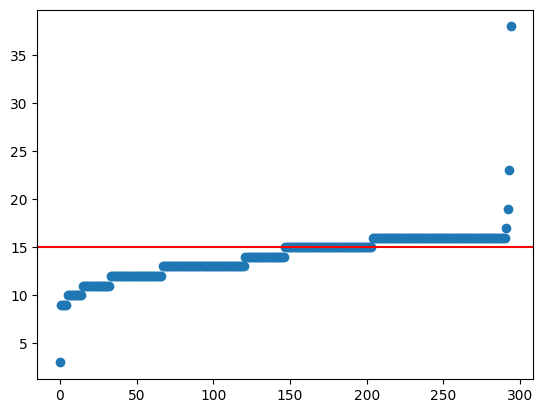

Mean number of frames:  14.084745762711865


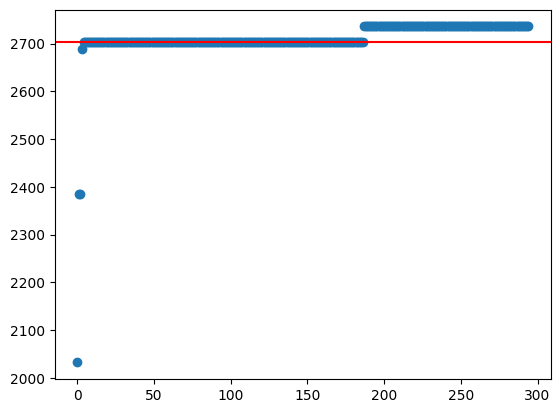

Mean length:  2711.2135593220337


In [37]:
# plot frames
x= np.arange(0,len(all_frame_numbers))
all_frame_numbers.sort()
plt.scatter(x,all_frame_numbers)
# plot horizontal line for minimum number of frames
plt.axhline(minimum_frames, color='r')
plt.show()
mean_number_of_frames = np.mean(all_frame_numbers)
print('Mean number of frames: ', mean_number_of_frames)


# plot lengths
x= np.arange(0,len(all_lengths))
all_lengths.sort()
plt.scatter(x,all_lengths)
# plot horizontal line for minimum length
plt.axhline(minimum_length, color='r')
plt.show()
mean_length = np.mean(all_lengths)
print('Mean length: ', mean_length)


In [ ]:
# shorten arrays on the same frame size (C3 -> 27, L15 -> 15), save each frame in a separate file and transform data into h5-files

transducer = transformation_transducer
frame_length = transformation_frame_length
number_of_frames = transformation_number_number_of_frames

directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data_'+version
new_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Shortened_data_h5_'+str(frame_length)+'px_'+str(number_of_frames)+'frames_'+transducer+'_'+version
# create new directory for shortened data
if not os.path.exists(new_directory):
    os.mkdir(new_directory)

for dir in tqdm(os.listdir(directory)):
    if os.path.isdir(directory+"/"+dir):
        for file in os.listdir(directory+"/"+dir):
            if transducer+'_large' in file and 'rf_no_tgc.npy' in file:
                data = np.load(directory+"/"+dir+"/"+file)
                # shorten data in axial depth
                if len(data[0,:,0]) >= frame_length:
                    shortened_data = data[:,:frame_length,:]

                    # shorten data in frame length
                    if len(data[0,0,:]) >= number_of_frames:
                        shortened_data = shortened_data[:,:,:number_of_frames]
                        for frame in range(0,len(shortened_data[0,0,:])):
                            try: 
                                single_frame_array = shortened_data[:,:,frame]
                            except:
                                print('Error in file: '+file)
                            with h5py.File(new_directory+'/'+dir+'_f'+f"{frame:02d}"+'_'+file[:(6+len(transducer))]+'.h5','w') as f:
                                f.create_dataset('augmented',data=[False]*len(single_frame_array[:,0]))
                                #f.create_dataset('coords',data=[[0,0]]*len(single_frame_array[:,0]))
                                f.create_dataset('feats',data=single_frame_array)
                            f.close()
                    else:
                        print('File '+dir+'/'+file+' has too few frames (only '+str(len(data[0,0,:]))+' frames)')
                else:
                    print('File '+dir+'/'+file+' is too short (only '+str(len(data[0,:,0]))+' pixels in axial direction)')
    

# create slide table with all patients and their corresponding frames
slide_table_dict = {'Patient_ID': [], 'Frame_number': [], 'Filename': []}
for file in os.listdir(new_directory):
    slide_table_dict['Patient_ID'].append(file[:6])
    slide_table_dict['Frame_number'].append(file[:7]+file[8:10])
    slide_table_dict['Filename'].append(file[:-3])

slide_table_df = pd.DataFrame(slide_table_dict)

slide_table_df.to_csv('/Volumes/Extreme_SSD/Targets/slide_table_'+transducer+'_'+str(frame_length)+'px_'+str(number_of_frames)+'frames_'+version+'.csv', index=False)
slide_table_df.to_excel('/Volumes/Extreme_SSD/Targets/slide_table_'+transducer+'_'+str(frame_length)+'px_'+str(number_of_frames)+'frames_'+version+'.xlsx', index=False)


In [ ]:
# search specific recordings based on their array dimensions

directory = 'Data/Finished_data'+version
all_lengths = []

for dir in os.listdir(directory):
    if os.path.isdir(directory+"/"+dir):
        for name in os.listdir(directory+"/"+dir):
            if 'C3_large' in name and 'rf_no_tgc.npy' in name:
                array = np.load(directory+"/"+dir+"/"+name)
                one_length = len(array[0,:,0])
                all_lengths.append(one_length)
                if one_length > 3500:
                    print(dir, one_length)
                    

In [ ]:
# transform shortened arrays with different numbers of frames to h5 files

import h5py

frame_length = transformation_frame_length
transducer = transformation_transducer
number_of_frames = transformation_number_number_of_frames

directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Shortened_data_npy_'+str(frame_length)+'px_230224'
#create new directory for h5 files
if not os.path.exists('/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Shortened_data_h5_'+str(frame_length)+'px'+'_'+str(number_of_frames)+'frames_'+transducer+'_230224'):
    os.makedirs()

for file in tqdm(os.listdir(directory)):
        # f = h5py.File('/Users/jakobschaefer/Downloads/jakob/Beispielvektor1.h5','r')

        if file.startswith('.'):
            os.remove(directory+'/'+file)
        try:
            np_array = np.load(directory+'/'+file)
        except:
            print(print(directory + "/" + file))

        with h5py.File('/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Shortened_data_h5_'+str(frame_length)+'px_230224/'+file[:-3]+'h5', "w") as f:
            dset = f.create_dataset("feats", data = np_array, dtype='i')

        f.close()


        #f = h5py.File('/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Shortened_data_h5_230224/'+file[:-3]+'h5','r')
        #print(f['array'].shape)

### Copy files with and/or without tgc into new folder (for AI-implementation by Tim)

In [20]:
# define start and end directory
version = 'Vortraining_Tim'
transducer = 'C3' # 'C3' or 'L15
TGC = 'with_and_without_TGC' # 'with_TGC' or 'without_TGC' or 'with_and_without_TGC'

start_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Finished_data_'+version
end_directory = '/Volumes/Extreme_SSD/Aufnahmen_vorverarbeitet/Exports_for_Tim/'+transducer+'_'+TGC+'_'+version

# create new directory for data with and without TGC
if not os.path.exists(end_directory):
    os.mkdir(end_directory)

# load arrays and copy them
for dir in tqdm(os.listdir(start_directory)):
    if dir.startswith('.'):
        try:
            os.rmdir(start_directory+'/'+dir)
            os.remove(start_directory+'/'+dir)
        except:
            pass
    else:
        for file in os.listdir(start_directory+'/'+dir):
            if file.startswith('.'):
                os.remove(start_directory+'/'+dir+'/'+file)
            else:
                if transducer in file and '_large' in file and 'rf_no_tgc.npy' in file:
                    if TGC == 'with_and_without_TGC':
                        shutil.copy(start_directory+'/'+dir+'/'+file, end_directory+'/'+dir+'_'+file[:-14]+'_rf_no_tgc.npy')
                        shutil.copy(start_directory+'/'+dir+'/'+file[:-11]+'.npy', end_directory+'/'+dir+'_'+file[:-14]+'_rf.npy')
                    if TGC == 'with_TGC':
                        shutil.copy(start_directory+'/'+dir+'/'+file[:-11]+'.npy', end_directory+'/'+dir+'_'+file[:-14]+'_rf.npy')
                    if TGC == 'without_TGC':
                        shutil.copy(start_directory+'/'+dir+'/'+file, end_directory+'/'+dir+'_'+file[:-14]+'_rf_no_tgc.npy')


  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
# save targets as csv
# get results out of RedCap-Survey (csv)
df = pd.read_csv(r'/Users/jakobschaefer/Documents/REDCap_Survey_'+version+'.csv')

Patient_ID = df['patients_id'].tolist()
Median_E = df['median_e'].tolist()
IQR_E = df['iqr_e'].tolist()
Median_CAP = df['median_cap'].tolist()
IQR_CAP = df['iqr_cap'].tolist()

target_dict = {'Patient_ID': Patient_ID, 'Median_E': Median_E, 'Median_CAP': Median_CAP} #, 'IQR_E': IQR_E, 'IQR_CAP': IQR_CAP
# remove rows that contain NaN-values
target_df = pd.DataFrame(target_dict).dropna() # remove lines without values

# check if there are any recordings without results or results without recordings
for file in os.listdir(end_directory):
    if not file[:6] in target_df['Patient_ID'].tolist() and not file[:9] in target_df['Patient_ID'].tolist():
        
        print(file[:file.find('_')]+' has no results')

# safe target_dict as csv
target_df.to_csv('/Volumes/Extreme_SSD/Targets/targets_'+transducer+'_'+version+'.csv', index=False)